In [1]:
#%pip install tf-keras openpyxl seaborn transformers nltk wordcloud


In [2]:
import nltk
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import re
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import string
import matplotlib.pyplot as plt
from transformers import pipeline
from wordcloud import WordCloud
nltk.download('stopwords')
print(torch.__version__)

# Checking if NVIDIA Graphics Card and CUDA is available
gpu_available = torch.cuda.is_available()

if gpu_available:
    print('Parallely Processing using CUDA')
else:
    print('No CUDA Detected')

2.2.2+cu121
Parallely Processing using CUDA


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WinTo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def text_preprocessing(text):
    # Normalize text to lowercase
    text = text.lower()
    
    # Use regular expressions to remove all characters that are not letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Split text into words (tokens)
    words = text.split()
    
    # Load a set of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]
    
    return filtered_words

def pad_features(encoded_texts, sequence_length=200):
    features = np.zeros((len(encoded_texts), sequence_length), dtype=int)
    for i, row in enumerate(encoded_texts):
        features[i, -len(row):] = np.array(row)[:sequence_length]
    return features

def load_data(filename):
    df = pd.read_csv(filename)
    df['processed_text'] = df['Sentence'].apply(text_preprocessing)
    return df

def create_vocab_and_encode(df):
    all_words = [word for text in df['processed_text'] for word in text]
    counts = Counter(all_words)
    vocab = sorted(counts, key=counts.get, reverse=True)
    vocab_to_int = {word: i+1 for i, word in enumerate(vocab)}  # ensure indexing starts from 1
    df['encoded'] = df['processed_text'].apply(lambda x: [vocab_to_int[word] for word in x])
    vocab_size = len(vocab_to_int) 
    return df, vocab_to_int, vocab_size

In [4]:
#load dataset
df = load_data('output_from_amazon_imdb_yelp.csv')

df, vocab_to_int, vocab_size = create_vocab_and_encode(df)
sequence_length = 200
features = pad_features(list(df['encoded']), sequence_length)
labels = df['Sentiment'].values
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [5]:

# Embedding Dimension of Tokens
embedding_dim = 400
# Embedding Dimension of Hidden Layers
hidden_dim = 256
# Output of the model is binary (either Positive or Negative)
output_size = 1
# Number of hidden LSTM cells
n_layers = 2

In [6]:
# Structure of the Neural Network
class LSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding_layer(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        weights = next(self.parameters()).data
        if gpu_available:
            hidden = (weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weights.new(self.n_layers, batch_size, self.hidden_dim).zero_(),weights.new(self.n_layers, batch_size, self.hidden_dim).zero())
        return hidden

net = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
# Move model to GPU if available
if gpu_available:
    net.cuda()
# Hyperparameters required for training of the network
# Learning Rate
lr = 0.001
# Loss Function - Binary Cross Entropy
criterion = nn.BCELoss()
# Gradient Descent based Optimizer - ADAM (Adaptive LR)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# Number of epochs to train the model
epochs = 8
count = 0
# Step size
print_every = 200
clip = 5 

In [7]:
# Initialize list to store average loss per epoch for training
losses = []
# Initialize lists to store per-batch losses for training and validation
batch_losses = []
val_batch_losses = []
# Begin training
net.train()
for e in range(epochs):
    running_loss = 0.0

    for inputs, labels in train_loader:
        current_batch_size = inputs.size(0)
        h = net.init_hidden(current_batch_size)
        count += 1
        
        if gpu_available:
            inputs, labels = inputs.cuda(), labels.cuda()
            h = tuple([each.data for each in h])
        
        net.zero_grad()
        outputs, h = net(inputs, h)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        running_loss += loss.item()
        batch_losses.append(loss.item())  # Append the loss of each batch

    # Calculate average loss for the epoch and store it
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)  # Append average loss per epoch to the list

    # Validation phase after each epoch
    val_h = net.init_hidden(batch_size)
    net.eval()
    val_losses = []

    for val_inputs, val_labels in valid_loader:
        if gpu_available:
            val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()
        val_outputs, val_h = net(val_inputs, val_h)
        val_loss = criterion(val_outputs.float(), val_labels.float())
        val_losses.append(val_loss.item())
        val_batch_losses.append(val_loss.item())  # Append validation batch loss
            
    net.train()

    # Print the training and validation losses after each epoch
    print(f"Epoch: {e+1}/{epochs}.....",
          f"Train Loss: {epoch_loss:.6f}......",
          f"Validation Loss: {np.mean(val_losses):.6f}")
#save the model
torch.save(net.state_dict(), 'sentiment_analysis_model.pth')

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


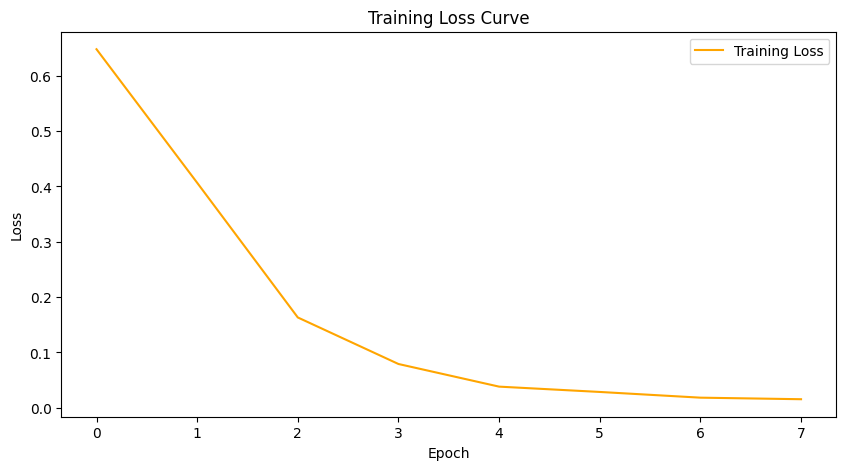

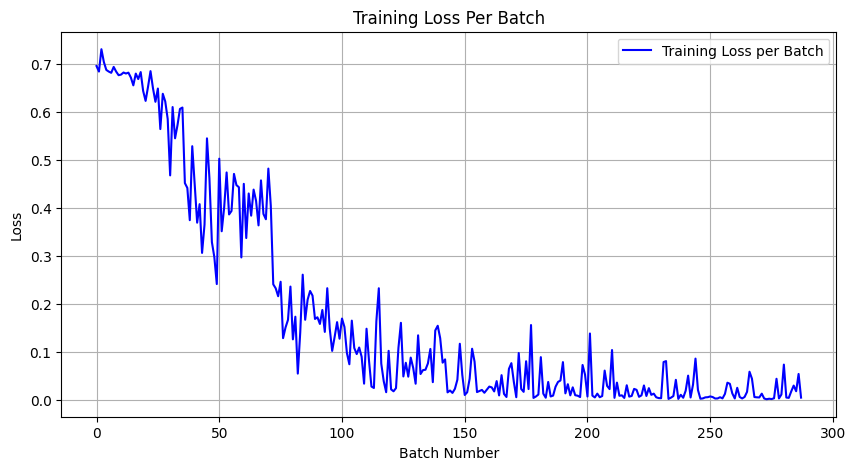

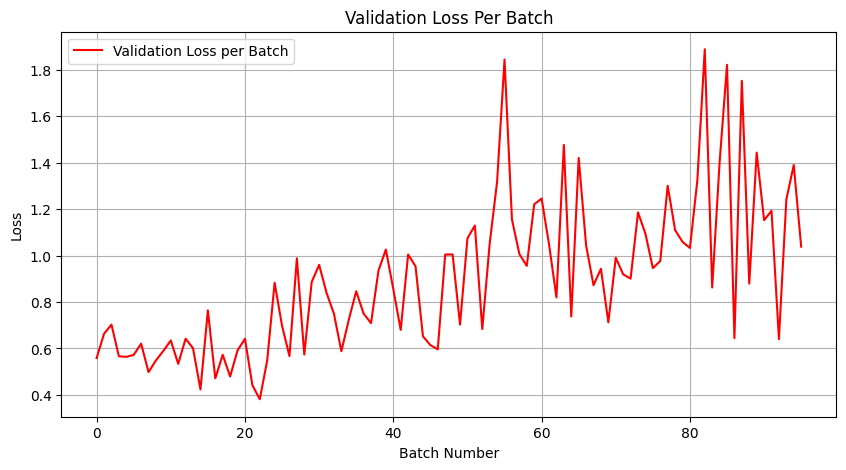

In [8]:
#Plot for Training Loss per Epoch
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss', color='orange')  # Color changed for visibility
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot for Training Loss per Batch
plt.figure(figsize=(10, 5))
plt.plot(batch_losses, label='Training Loss per Batch', color='blue')
plt.title('Training Loss Per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Validation Loss per Batch
plt.figure(figsize=(10, 5))
plt.plot(val_batch_losses, label='Validation Loss per Batch', color='red')
plt.title('Validation Loss Per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# evaluating the model
# Initialize the model
loaded_net = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
# Move model to GPU if available
if gpu_available:
    loaded_net.cuda()
else:
    loaded_net.cpu()  # Ensuring model is on CPU if GPU is not available
# Load the saved model parameters
loaded_net.load_state_dict(torch.load("sentiment_analysis_model.pth"))

# Set the model to evaluation mode
loaded_net.eval()

LSTM(
  (embedding_layer): Embedding(5174, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [10]:
all_preds = []
all_labels = []

# Ensure the model is on the right device and set to evaluation mode
model = loaded_net  # Ensure this is the trained model instance
model.eval()  # Set the model to evaluation mode to disable dropout, etc.

if gpu_available:
    model.cuda()  # Move model to GPU if available
else:
    model.cpu()  # Ensuring model is on CPU if GPU is not available

# Prediction loop
for inputs, labels in test_loader:
    current_batch_size = inputs.size(0)
    h = model.init_hidden(current_batch_size)

    # Move inputs and labels to the same device as the model
    if gpu_available:
        inputs, labels = inputs.cuda(), labels.cuda()
    else:
        inputs, labels = inputs.cpu(), labels.cpu()
    
    outputs, h = model(inputs, h)
    preds = torch.round(outputs.squeeze())
    # Detach the predictions and move back to CPU for collecting, if they are on GPU
    # Ensure preds and labels are in array form even if they're scalar
    preds = preds.detach().cpu().numpy()
    preds = preds.flatten()  # Ensure it is a 1D array, safe if already 1D
    all_preds.extend(preds)
    labels = labels.cpu().numpy()
    labels = labels.flatten()  # Similarly ensure labels are 1D
    all_labels.extend(labels)

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [25]:
# preds to arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [26]:
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 800x600 with 0 Axes>

In [27]:
from sklearn.metrics import classification_report
class_rep = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(class_rep)

ValueError: Number of classes, 0, does not match size of target_names, 2. Try specifying the labels parameter